In [1]:
!pip install livelossplot

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os
%matplotlib inline

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
from livelossplot import PlotLossesKerasTF
import tensorflow as tf

In [3]:
# 구글 드라이브에 마운트
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# 데이터셋 경로
filepath = '/content/gdrive/My Drive/face/'

In [5]:
# train 파일 데이터셋 갯수
for expression in os.listdir(filepath + "train/"):
    print(str(len(os.listdir(filepath + "train/" + expression))) +" "+ expression)

274 Neutral
345 Sadness
325 Happiness
165 Fear
323 Anger


In [6]:
# 이미지 크기, 배치 사이즈

batch_size = 64

# ImageDataGenerator 파일을 불러 올 때 카테고리도 같이 확인
# train 데이터를 ImageDataGenerator를 사용해 가공
datagen_train = ImageDataGenerator(horizontal_flip=True)


train_generator = datagen_train.flow_from_directory(
    filepath + "train/", target_size=(128,128),
    color_mode = "grayscale", batch_size = batch_size,
    class_mode = 'categorical', shuffle = True)

# validation 데이터를 ImageDataGenerator를 사용해 가공
datagen_validation = ImageDataGenerator(horizontal_flip=True)

validation_generator = datagen_validation.flow_from_directory(
    filepath + "valid/",target_size=(128,128),
    color_mode="grayscale", batch_size=batch_size,
    class_mode='categorical', shuffle=False)

Found 1427 images belonging to 5 classes.
Found 180 images belonging to 5 classes.


In [7]:
# 합성곱 신경망
model = Sequential()

# Conv2D([필터],(kernel_size[필터의 크기]), padding='same', input_shape=(48, 48,1))
# model.add(BatchNormalization()) 배치 정규화       ㄴinput_shape 값과 같다.
# 풀링은 합성곱에 의해 얻어진 Feature map으로부터 값을 샘플링해서 정보를 압축하는 과정을 의미합니다.
# Max-pooling은 특정 영역에서 가장 큰 값을 샘플링하는 풀링 방식
# dropout(0.25) 1/4 드랍

# 1번째 합성곱
model.add(Conv2D(64,(3,3), padding='same', input_shape=(128, 128,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2번째 합성곱
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3번째 합성곱
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4번째 합성곱
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())

# 완전 연결 계층 1층
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# 완전 연결 계층 2층
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


model.add(Dense(5, activation='softmax')) # 출력 노드 5개

opt = Adam(lr=0.0005) # 학습률 0.0005
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy']) # 모델학습과정
model.summary() # sequential 신경망 정보 출력

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      640       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 128, 128, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 128)       5

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


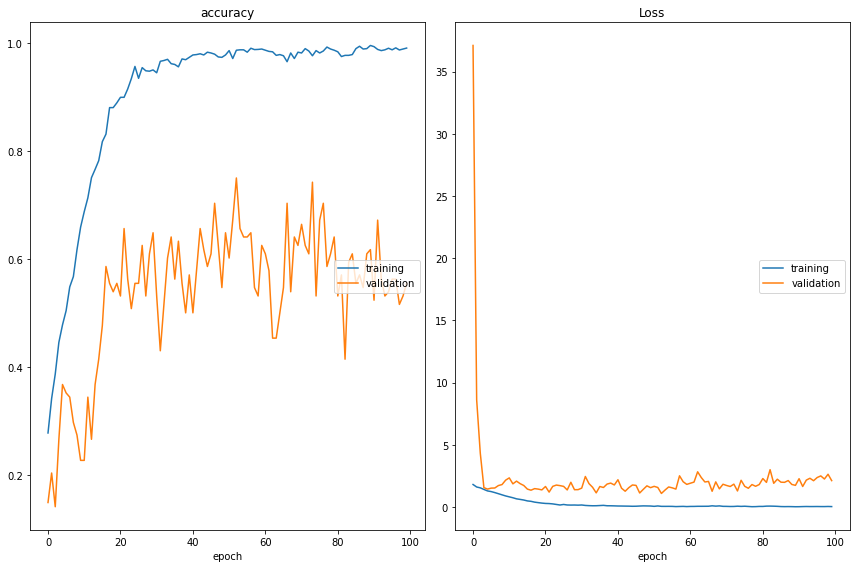

accuracy
	training         	 (min:    0.277, max:    0.996, cur:    0.991)
	validation       	 (min:    0.141, max:    0.750, cur:    0.555)
Loss
	training         	 (min:    0.020, max:    1.807, cur:    0.032)
	validation       	 (min:    1.088, max:   37.096, cur:    2.120)

Epoch 00100: saving model to /content/gdrive/My Drive/model_weights.h5
CPU times: user 18min 38s, sys: 57.5 s, total: 19min 35s
Wall time: 33min 11s


In [8]:
%%time

steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.01, mode='auto')
checkpoint = ModelCheckpoint("/content/gdrive/My Drive/model_weights.h5", monitor='val_accuracy', save_weights_only=True, mode='max', verbose=1)
callbacks = [PlotLossesKerasTF(), checkpoint, reduce_lr]

history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks = callbacks
)

In [15]:
loss_and_metrics = model.evaluate(validation_generator, batch_size = 64)
print(loss_and_metrics)

3/3 [==============================] - 2s 946ms/step - loss: 2.2674 - accuracy: 0.5278
[2.2674343585968018, 0.5277777910232544]


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


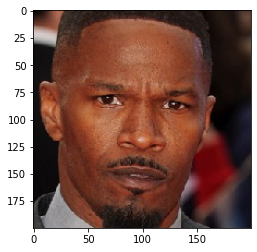

Expression Prediction: Anger


In [14]:
from skimage import io
img = image.load_img('/content/gdrive/My Drive/face/valid/Anger/0c820f5bd193561673064e60cc2f78f74b0d4cbf65260d2a19566db5.jpg', grayscale=True, target_size=(128, 128))
show_img=image.load_img('/content/gdrive/My Drive/face/valid/Anger/0c820f5bd193561673064e60cc2f78f74b0d4cbf65260d2a19566db5.jpg', grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)

x = np.array(x, 'float32')
x = x.reshape([128, 128]);

plt.gray()
plt.imshow(show_img)
plt.show()

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i
        
print('Expression Prediction:',expression)